# Подключение бибилиотек

In [1]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary
import copy

# Загрузка датасета

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print( f"Размер обучаемой выборки x: {train_dataset.data.shape}. y: {len(train_dataset.targets)}" )
print( f"Размер тестовой выборки: {test_dataset.data.shape} * {len(test_dataset.targets)}" )

results = [("MY", 0.7571)]
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Размер обучаемой выборки x: (50000, 32, 32, 3). y: 50000
Размер тестовой выборки: (10000, 32, 32, 3) * 10000


# Функции обучения

In [4]:
def TrainModel(model, train_loader, criterion, optimizer, num_epochs):
    start_time = time.time()
    model.train()
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        timer2 = time.time()
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

        print('Эпоха {}/{}. Ошибка классификации: {:.4f}. Точность: {:.2f}%. Время: {:.2f} сек'
                  .format(epoch + 1, num_epochs, loss.item(), (correct / total) * 100, time.time() - timer2) )

    print(f"Общее время обучения: {time.time() - start_time:.4f} сек")

def TestModel(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Точность на тестовом наборе данных:", correct / total)
    return correct / total

# Загрузка обученных моделей

## Resnet50

In [5]:
modelResnet50 = models.resnet50(pretrained=True)
modelResnet50.fc = nn.Linear(2048, 10)

modelResnet50V1 = copy.deepcopy(modelResnet50)
modelResnet50V2 = copy.deepcopy(modelResnet50)
optimizer = torch.optim.Adam(modelResnet50.parameters(), lr=0.001)

TrainModel(modelResnet50, train_loader, criterion, optimizer, 5)
acc = TestModel(modelResnet50, test_loader)
results.append(("modelResnet50",acc))

print("Исходная архитектура:")
summary(modelResnet50, (3,32,32))

C:\Users\nikita\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nikita\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nikita/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 27.6MB/s]


Эпоха 1/5. Ошибка классификации: 0.9576. Точность: 65.00%. Время: 154.39 сек
Эпоха 2/5. Ошибка классификации: 0.4401. Точность: 86.25%. Время: 152.98 сек
Эпоха 3/5. Ошибка классификации: 0.3463. Точность: 90.00%. Время: 159.01 сек
Эпоха 4/5. Ошибка классификации: 0.3016. Точность: 87.50%. Время: 154.67 сек
Эпоха 5/5. Ошибка классификации: 0.7714. Точность: 73.75%. Время: 150.34 сек
Общее время обучения: 771.3841 сек
Точность на тестовом наборе данных: 0.7512
Исходная архитектура:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
  

## Resnet50V1

In [6]:
modelResnet50V1.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(True),
    nn.Linear(128, 10))
optimizer = torch.optim.Adam(modelResnet50V1.parameters(), lr=0.001)

TrainModel(modelResnet50V1, train_loader, criterion, optimizer, 5)
acc = TestModel(modelResnet50V1, test_loader)
results.append(("modelResnet50V1",acc))

print("Первый вариант архитектуры:")
summary(modelResnet50V1, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.6488. Точность: 77.50%. Время: 164.11 сек
Эпоха 2/5. Ошибка классификации: 0.5082. Точность: 82.50%. Время: 160.22 сек
Эпоха 3/5. Ошибка классификации: 0.4522. Точность: 90.00%. Время: 157.24 сек
Эпоха 4/5. Ошибка классификации: 0.3155. Точность: 86.25%. Время: 156.27 сек
Эпоха 5/5. Ошибка классификации: 0.2580. Точность: 91.25%. Время: 157.83 сек
Общее время обучения: 795.6675 сек
Точность на тестовом наборе данных: 0.8021
Первый вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             

## Resnet50V2

In [7]:
modelResnet50V2.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Linear(512, 10))
optimizer = torch.optim.Adam(modelResnet50V2.parameters(), lr=0.001)

TrainModel(modelResnet50V2, train_loader, criterion, optimizer, 5)
acc = TestModel(modelResnet50V2, test_loader)
results.append(("modelResnet50V2",acc))

print("Второй вариант архитектуры:")
summary(modelResnet50V2, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.7001. Точность: 75.00%. Время: 156.36 сек
Эпоха 2/5. Ошибка классификации: 0.5187. Точность: 86.25%. Время: 155.57 сек
Эпоха 3/5. Ошибка классификации: 0.3660. Точность: 88.75%. Время: 157.20 сек
Эпоха 4/5. Ошибка классификации: 0.4219. Точность: 88.75%. Время: 161.63 сек
Эпоха 5/5. Ошибка классификации: 0.2259. Точность: 93.75%. Время: 161.04 сек
Общее время обучения: 791.8126 сек
Точность на тестовом наборе данных: 0.8148
Второй вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             

## ConvNeXt

In [8]:
modelConvNeXt = models.convnext_tiny(pretrained=True)
modelConvNeXt.classifier[2] = nn.Linear(768, 10)

modelConvNeXtV1 = copy.deepcopy(modelConvNeXt)
modelConvNeXtV2 = copy.deepcopy(modelConvNeXt)
optimizer = torch.optim.Adam(modelConvNeXt.parameters(), lr=0.001)

TrainModel(modelConvNeXt, train_loader, criterion, optimizer, 5)
acc = TestModel(modelConvNeXt, test_loader)
results.append(("modelConvNeXt",acc))

print("Исходная архитектура:")
summary(modelConvNeXt, (3,32,32))

C:\Users\nikita\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\nikita/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|███████████████████████████████████████████████████████████████████████████████| 109M/109M [00:05<00:00, 22.5MB/s]


Эпоха 1/5. Ошибка классификации: 0.4404. Точность: 85.00%. Время: 228.31 сек
Эпоха 2/5. Ошибка классификации: 0.5788. Точность: 77.50%. Время: 242.69 сек
Эпоха 3/5. Ошибка классификации: 0.3971. Точность: 85.00%. Время: 246.07 сек
Эпоха 4/5. Ошибка классификации: 0.3890. Точность: 87.50%. Время: 244.40 сек
Эпоха 5/5. Ошибка классификации: 0.3978. Точность: 87.50%. Время: 251.09 сек
Общее время обучения: 1212.5541 сек
Точность на тестовом наборе данных: 0.84
Исходная архитектура:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
       LayerNorm2d-2             [-1, 96, 8, 8]             192
            Conv2d-3             [-1, 96, 8, 8]           4,800
           Permute-4             [-1, 8, 8, 96]               0
         LayerNorm-5             [-1, 8, 8, 96]             192
            Linear-6            [-1, 8, 8, 384]          37,248
   

## ConvNeXtV1

In [9]:
modelConvNeXtV1.classifier[2] = nn.Linear(768, 128)
modelConvNeXtV1.classifier.append( nn.ReLU(True) )
modelConvNeXtV1.classifier.append( nn.Linear(128, 10) )
optimizer = torch.optim.Adam(modelConvNeXtV1.parameters(), lr=0.001)

TrainModel(modelConvNeXtV1, train_loader, criterion, optimizer, 5)
acc = TestModel(modelConvNeXtV1, test_loader)
results.append(("modelConvNeXtV1",acc))

print("Первый вариант архитектуры:")
summary(modelConvNeXtV1, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.7080. Точность: 78.75%. Время: 238.31 сек
Эпоха 2/5. Ошибка классификации: 0.4200. Точность: 81.25%. Время: 252.84 сек
Эпоха 3/5. Ошибка классификации: 0.4223. Точность: 87.50%. Время: 263.24 сек
Эпоха 4/5. Ошибка классификации: 0.3937. Точность: 85.00%. Время: 260.58 сек
Эпоха 5/5. Ошибка классификации: 0.2425. Точность: 92.50%. Время: 260.21 сек
Общее время обучения: 1275.1719 сек
Точность на тестовом наборе данных: 0.8479
Первый вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
       LayerNorm2d-2             [-1, 96, 8, 8]             192
            Conv2d-3             [-1, 96, 8, 8]           4,800
           Permute-4             [-1, 8, 8, 96]               0
         LayerNorm-5             [-1, 8, 8, 96]             192
            Linear-6            [-1, 8, 8, 384]          37

## ConvNeXtV2

In [10]:
modelConvNeXtV2.classifier[2] = nn.Linear(768, 512)
modelConvNeXtV2.classifier.append( nn.ReLU(True) )
modelConvNeXtV2.classifier.append( nn.Linear(512, 256) )
modelConvNeXtV2.classifier.append( nn.ReLU(True) )
modelConvNeXtV2.classifier.append( nn.Linear(256, 10) )
optimizer = torch.optim.Adam(modelConvNeXtV2.parameters(), lr=0.001)

TrainModel(modelConvNeXtV2, train_loader, criterion, optimizer, 5)
acc = TestModel(modelConvNeXtV2, test_loader)
results.append(("modelConvNeXtV2",acc))

print("Второй вариант архитектуры:")
summary(modelConvNeXtV2, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.6994. Точность: 80.00%. Время: 252.82 сек
Эпоха 2/5. Ошибка классификации: 0.4542. Точность: 83.75%. Время: 263.58 сек
Эпоха 3/5. Ошибка классификации: 0.2717. Точность: 92.50%. Время: 265.42 сек
Эпоха 4/5. Ошибка классификации: 0.2126. Точность: 92.50%. Время: 259.57 сек
Эпоха 5/5. Ошибка классификации: 0.2242. Точность: 92.50%. Время: 267.35 сек
Общее время обучения: 1308.7469 сек
Точность на тестовом наборе данных: 0.8204
Второй вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
       LayerNorm2d-2             [-1, 96, 8, 8]             192
            Conv2d-3             [-1, 96, 8, 8]           4,800
           Permute-4             [-1, 8, 8, 96]               0
         LayerNorm-5             [-1, 8, 8, 96]             192
            Linear-6            [-1, 8, 8, 384]          37

## GoogLeNet

In [11]:
modelGoogleNet = models.googlenet(pretrained=True)
modelGoogleNet.fc = nn.Sequential(
    nn.Linear(1024, 10))
modelGoogleNetV1 = copy.deepcopy(modelGoogleNet)
modelGoogleNetV2 = copy.deepcopy(modelGoogleNet)
optimizer = torch.optim.Adam(modelGoogleNet.parameters(), lr=0.001)

TrainModel(modelGoogleNet, train_loader, criterion, optimizer, 5)
acc = TestModel(modelGoogleNet, test_loader)
results.append(("modelGoogleNet",acc))

print("Исходная архитектура:")
summary(modelGoogleNet, (3,32,32))

C:\Users\nikita\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\nikita/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:02<00:00, 24.4MB/s]


Эпоха 1/5. Ошибка классификации: 0.8246. Точность: 76.25%. Время: 68.67 сек
Эпоха 2/5. Ошибка классификации: 0.6473. Точность: 73.75%. Время: 70.75 сек
Эпоха 3/5. Ошибка классификации: 0.7322. Точность: 77.50%. Время: 70.71 сек
Эпоха 4/5. Ошибка классификации: 0.4481. Точность: 78.75%. Время: 70.74 сек
Эпоха 5/5. Ошибка классификации: 0.3016. Точность: 90.00%. Время: 68.94 сек
Общее время обучения: 349.8049 сек
Точность на тестовом наборе данных: 0.8134
Исходная архитектура:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       

## GoogLeNetV1

In [12]:
modelGoogleNetV1.fc = nn.Sequential(
    nn.Linear(1024, 128),
    nn.ReLU(True),
    nn.Linear(128, 10))
optimizer = torch.optim.Adam(modelGoogleNetV1.parameters(), lr=0.001)

TrainModel(modelGoogleNetV1, train_loader, criterion, optimizer, 5)
acc = TestModel(modelGoogleNetV1, test_loader)
results.append(("modelGoogleNetV1",acc))

print("Первый вариант архитектуры:")
summary(modelGoogleNetV1, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.7075. Точность: 76.25%. Время: 70.51 сек
Эпоха 2/5. Ошибка классификации: 0.5184. Точность: 83.75%. Время: 70.47 сек
Эпоха 3/5. Ошибка классификации: 0.4977. Точность: 85.00%. Время: 71.03 сек
Эпоха 4/5. Ошибка классификации: 0.4536. Точность: 85.00%. Время: 72.19 сек
Эпоха 5/5. Ошибка классификации: 0.2176. Точность: 91.25%. Время: 73.74 сек
Общее время обучения: 357.9428 сек
Точность на тестовом наборе данных: 0.8128
Первый вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
 

## GoogLeNetV2

In [13]:
modelGoogleNetV2.fc = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Linear(512, 128),
    nn.ReLU(True),
    nn.Linear(128, 10))
optimizer = torch.optim.Adam(modelGoogleNetV2.parameters(), lr=0.001)

TrainModel(modelGoogleNetV2, train_loader, criterion, optimizer, 5)
acc = TestModel(modelGoogleNetV2, test_loader)
results.append(("modelGoogleNetV2",acc))

print("Второй вариант архитектуры:")
summary(modelGoogleNetV2, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.7833. Точность: 75.00%. Время: 71.19 сек
Эпоха 2/5. Ошибка классификации: 0.6664. Точность: 80.00%. Время: 71.43 сек
Эпоха 3/5. Ошибка классификации: 0.4406. Точность: 82.50%. Время: 71.14 сек
Эпоха 4/5. Ошибка классификации: 0.4596. Точность: 80.00%. Время: 71.43 сек
Эпоха 5/5. Ошибка классификации: 0.2896. Точность: 90.00%. Время: 70.97 сек
Общее время обучения: 356.1530 сек
Точность на тестовом наборе данных: 0.8151
Второй вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
 

## MNASNet

In [14]:
modelMNASNet = models.mnasnet1_0(pretrained=True)
modelMNASNet.classifier[1] = nn.Linear(1280, 10)

modelMNASNetV1 = copy.deepcopy(modelMNASNet)
optimizer = torch.optim.Adam(modelMNASNet.parameters(), lr=0.001)

TrainModel(modelMNASNet, train_loader, criterion, optimizer, 5)
acc = TestModel(modelMNASNet, test_loader)
results.append(("modelMNASNet",acc))

print("Исходная архитектура:")
summary(modelMNASNet, (3,32,32))

C:\Users\nikita\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\nikita/.cache\torch\hub\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth
100%|█████████████████████████████████████████████████████████████████████████████| 16.9M/16.9M [00:00<00:00, 25.0MB/s]


Эпоха 1/5. Ошибка классификации: 0.5879. Точность: 77.50%. Время: 475.02 сек
Эпоха 2/5. Ошибка классификации: 0.6192. Точность: 77.50%. Время: 445.76 сек
Эпоха 3/5. Ошибка классификации: 0.5730. Точность: 80.00%. Время: 399.16 сек
Эпоха 4/5. Ошибка классификации: 0.3190. Точность: 90.00%. Время: 398.90 сек
Эпоха 5/5. Ошибка классификации: 0.3663. Точность: 85.00%. Время: 397.82 сек
Общее время обучения: 2116.6597 сек
Точность на тестовом наборе данных: 0.4965
Исходная архитектура:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
 

## MNASNetV1

In [15]:
modelMNASNetV1.classifier[1] = nn.Linear(1280, 128, True)
modelMNASNetV1.classifier.append( nn.ReLU(True) )
modelMNASNetV1.classifier.append( nn.Linear(128, 10) )
optimizer = torch.optim.Adam(modelMNASNetV1.parameters(), lr=0.001)

TrainModel(modelMNASNetV1, train_loader, criterion, optimizer, 5)
acc = TestModel(modelMNASNetV1, test_loader)
results.append(("modelMNASNetV1",acc))

print("Первый вариант архитектуры:")
summary(modelMNASNetV1, (3,32,32))

Эпоха 1/5. Ошибка классификации: 0.7189. Точность: 71.25%. Время: 531.48 сек
Эпоха 2/5. Ошибка классификации: 0.4421. Точность: 87.50%. Время: 405.20 сек
Эпоха 3/5. Ошибка классификации: 0.4927. Точность: 86.25%. Время: 420.12 сек
Эпоха 4/5. Ошибка классификации: 0.7677. Точность: 81.25%. Время: 402.12 сек
Эпоха 5/5. Ошибка классификации: 0.3753. Точность: 85.00%. Время: 404.53 сек
Общее время обучения: 2163.4522 сек
Точность на тестовом наборе данных: 0.5297
Первый вариант архитектуры:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]            

# Сравнение результатов

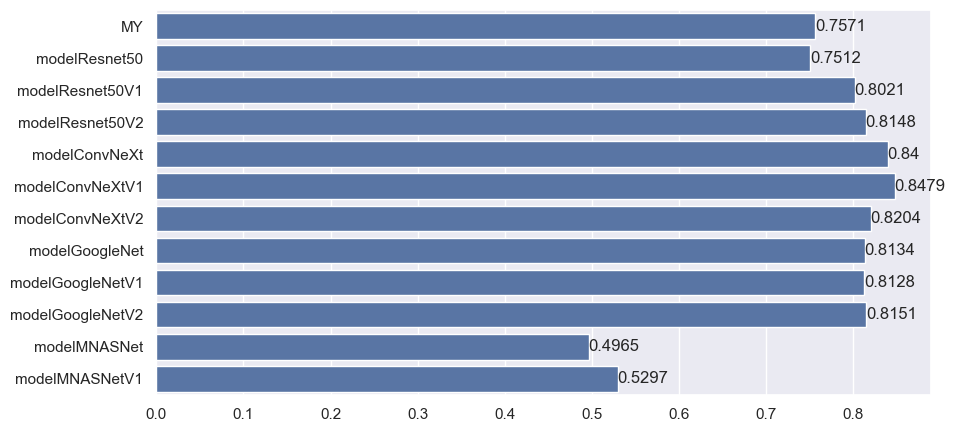

In [31]:
import seaborn
tmp = {}
for (name, acc) in results:
    tmp[name] = acc

seaborn.set( rc={'figure.figsize': (10, 5)} )

ax = seaborn.barplot(x=list(tmp.values()), y=list(tmp.keys()), orient="y")
for i in ax.containers:
    ax.bar_label(i,)

## Лучшая модель

In [32]:
best = max(tmp, key=lambda key: tmp[key])
print(f"Название: {best}")
print(f"Точность: {tmp[best]*100}%")
print(f"Коэффициент обучения: {0.001}")
print(f"Количество эпох: {5}")
print(f"Размер батчей: {128}")
print("Оптимизатор - Adam(model.parameters(), lr)")

Название: modelConvNeXtV1
Точность: 84.78999999999999%
Коэффициент обучения: 0.001
Количество эпох: 5
Размер батчей: 128
Оптимизатор - Adam(model.parameters(), lr)
